In [7]:
###### Importing important Modules #####

# Data and NBA API
import pandas as pd
import numpy as np

from scipy.stats import norm, gaussian_kde, percentileofscore

pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

sns.set_style('white')
sns.set_color_codes()

# for 3NG optimization calcs
from itertools import permutations

In [8]:
####### Function to check if point is within region #####

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.affinity

def find_court_location(x_loc, y_loc):
    """
    Takes in player shot location and outputs what region of the
    court they are on. The input must be a Point Object from
    shapely.geometry module.
    """
    
    player_shot_location = Point(x_loc,y_loc)
    
    ### Defining all possible areas of the court
    
    ## Rectangular Areas
    left_corner_three = Polygon([(-250, -47.5), (-250, 92.5), (-220, 92.5), (-220, -47.5)])
    right_corner_three = Polygon([(250, -47.5), (250, 92.5), (220, 92.5), (220, -47.5)])
    
    left_base_jump = Polygon([(-220, -47.5), (-220, 92.5), (-125, 92.5), (-125, -47.5)])
    right_base_jump = Polygon([(220, -47.5), (220, 92.5), (125, 92.5), (125, -47.5)])
    
    left_near_basket = Polygon([(-125, -47.5), (-125, 142.5), (0, 142.5), (0, -47.5)])
    right_near_basket = Polygon([(125, -47.5), (125, 142.5), (0, 142.5), (0, -47.5)])
    
    ## Left & Right Wing 2s
    circle = Point(0,0).buffer(1)
    three_circle = shapely.affinity.scale(circle, 237.5, 237.5)
    
    #making two polygons that contain the area that I want. 
    #If point is inside polygon area and circle then it is in long 2 area
    left_two_polygon = Polygon([(-250, 250), (-250, 92.5), (-125, 92.5), (-125, 250)])
    right_two_polygon = Polygon([(250, 250), (250, 92.5), (125, 92.5), (125, 250)])
     
    ## Left & Right Above FT 2s
    left_two_above_FT = Polygon([(-125, 250), (-125, 142.5), (0, 142.5), (0, 250)])
    right_two_above_FT = Polygon([(125, 250), (125, 142.5), (0, 142.5), (0, 250)])
    
    ## Above 3 point line
    big_circle = shapely.affinity.scale(circle, 287.5, 287.5)
    
    left_three_polygon = Polygon([(-250,300), (-250,0), (-125, 0), (-125, 300)])
    right_three_polygon = Polygon([(250,300), (250,0), (125, 0), (125, 300)])
    
    left_mid_three_polygon = Polygon([(-125,300), (-125,0), (0, 0), (0, 300)])
    right_mid_three_polygon = Polygon([(125,300), (125,0), (0, 0), (0, 300)])
    
    ## Dealing with Restricted Zone
    # Restricted zone below hoop (0,0)
    #left_restricted_line = Rectangle((-40, -47.5), 0, 47.5, linewidth=lw, color="red")
    restrict_below_hoop = Polygon([(-40,-47.5), (-40,0), (40, 0), (40, -47.5)])
    restrict_above_hoop = Polygon([(-40,0), (-40,40), (40, 40), (40, 0)])
    restrict_circle = shapely.affinity.scale(circle, 40, 40)

    
    ################### The below code is used to find a players given shot position given their X,Y coordinate #####
    if left_corner_three.contains(player_shot_location):
        return '3 pointer Left Corner'
    
    elif right_corner_three.contains(player_shot_location):
        return '3 pointer Right Corner'
        
    elif left_base_jump.contains(player_shot_location):
        return '2 pointer Left Baseline'
    
    elif right_base_jump.contains(player_shot_location):
        return '2 pointer Right Baseline'
        
    ##################### Restricted Zone ##################
    elif restrict_below_hoop.contains(player_shot_location):
        return 'Restricted Area'
        
    elif left_near_basket.contains(player_shot_location) & restrict_above_hoop.contains(player_shot_location) & restrict_circle.contains(player_shot_location):
        return 'Restricted Area'
        
    elif right_near_basket.contains(player_shot_location) & restrict_above_hoop.contains(player_shot_location) & restrict_circle.contains(player_shot_location):
        return 'Restricted Area'
        
    elif right_near_basket.contains(player_shot_location):
        return '2 pointer Left near basket'
        
    elif left_near_basket.contains(player_shot_location):
        return '2 pointer Right near basket'
    
    ######################################################
    elif three_circle.contains(player_shot_location) & left_two_polygon.contains(player_shot_location):
        return '2 pointer Left wing'
        
    elif three_circle.contains(player_shot_location) & right_two_polygon.contains(player_shot_location):
        return '2 pointer Right wing'
        
    elif three_circle.contains(player_shot_location) & left_two_above_FT.contains(player_shot_location):
        return '2 pointer Left above FT'
        
    elif three_circle.contains(player_shot_location) & right_two_above_FT.contains(player_shot_location):
        return '2 pointer Right above FT'
        
    elif big_circle.contains(player_shot_location) & left_three_polygon.contains(player_shot_location):
        return '3 pointer Left'
        
    elif big_circle.contains(player_shot_location) & right_three_polygon.contains(player_shot_location):
        return '3 pointer Right'
        
    elif big_circle.contains(player_shot_location) & left_mid_three_polygon.contains(player_shot_location):
        return '3 pointer Middle'
    
    elif big_circle.contains(player_shot_location) & right_mid_three_polygon.contains(player_shot_location):
        return '3 pointer Middle'       
    else:
        return 'Out of bounds'

In [9]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                         fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color="red")
    
    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
################# Below this line is my new code #######################
    
    #5 feet behind 3 point line
    four_arc = Arc((0, 0), 575, 575, theta1=22, theta2=158, linewidth=lw, color='red')
    
    corner_three_zone_a = Rectangle((-250, 92.5), 30, 0, linewidth=lw, color="red")
    corner_three_zone_b = Rectangle((220, 92.5), 30, 0, linewidth=lw, color="red")
    #low_left_zone = Rectangle((-125, -47.5), 125, 190, linewidth=lw, color="red", fill=False)
    #low_right_zone = Rectangle((0, -47.5), 125, 190, linewidth=lw, color="red", fill=False)
    baseline_jump_left = Rectangle((-220,-47.5), 0, 140, linewidth=lw, color="red", fill=False)
    baseline_jump_right = Rectangle((220,-47.5), 95, 140, linewidth=lw, color="red", fill=False)
    
    # Drawing 3 lines that will make divisions in mid range & 3-pointer territories
    left_line = Rectangle((-125, 200), 0, 60, linewidth=lw, color="red")
    right_line = Rectangle((125, 200), 0, 60, linewidth=lw, color="red")
    
    
    #adding line at FT that connects zones
    
    
    #adding two lines that connect restricted zones
    
    
################# Above this line is my new code #######################

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, inner_box, outer_box,top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc,center_outer_arc,
                      center_inner_arc, four_arc, corner_three_zone_a, corner_three_zone_b,
                      baseline_jump_left, baseline_jump_right,
                     left_line, right_line]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [10]:
def visualize_shot(x,y):
    
    find_court_location(x,y)
    
    plt.figure(figsize=(12,11))

    draw_court()
    
    # Adjust plot limits to just fit in half court
    plt.xlim(-250,250)
    
    # Descending values along th y axis from bottom to top
    # in order to place the hoop by the top of plot
    plt.ylim(422.5, -47.5)
    
    # get rid of axis tick labels
    plt.tick_params(labeltop=True, labelleft=True, labelbottom=False, labelright=True)
    plt.plot(x,y, marker='X', markersize=20, color = 'green')
    plt.show()

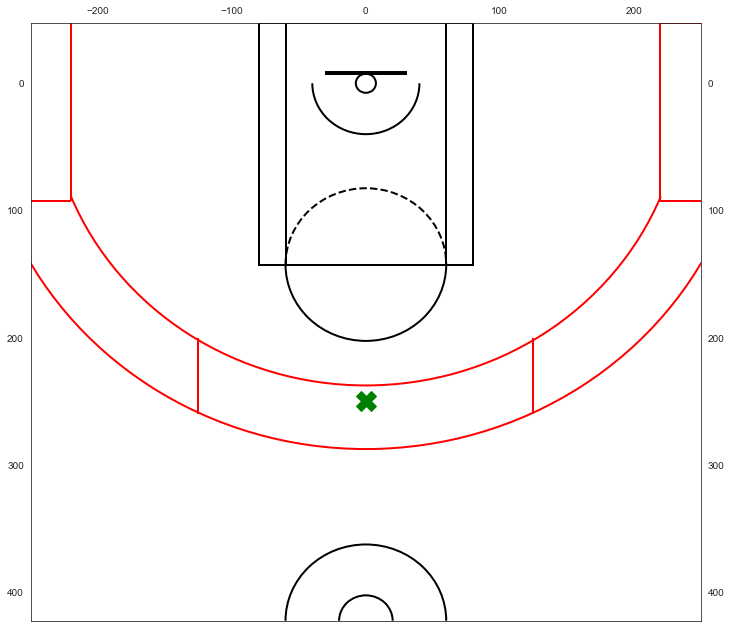

In [11]:
visualize_shot(0,250)

In [17]:
find_court_location(0,250)

'Out of bounds'

In [59]:
####### Function to check if point is within region #####

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.affinity

def find_court_location(x_loc, y_loc):
    """
    Takes in player shot location and outputs what region of the
    court they are on. The input must be a Point Object from
    shapely.geometry module.
    """
    
    player_shot_location = Point(x_loc,y_loc)
    
    ### Defining Relevant 3 point Areas
    
    ## Corner Threes
    left_corner_three = Polygon([(-250, -47.5), (-250, 92.5), (-220, 92.5), (-220, -47.5)])
    right_corner_three = Polygon([(250, -47.5), (250, 92.5), (220, 92.5), (220, -47.5)])
    
    # Circle inside 3 point line
    circle = Point(0,0).buffer(1)
    small_circle = shapely.affinity.scale(circle, 237.5, 237.5)
    
    # Circle inside defined 3 point line boundaries
    big_circle = shapely.affinity.scale(circle, 287.5, 287.5)
    
    #Left 3 Rectangle
    left_three = Polygon([(-250, 97.5), (-250, 300), (-125, 300), (-125, 97.5)])
    
    #Right 3 Rectangle
    right_three = Polygon([(250, 97.5), (250, 300), (125, 300), (125, 97.5)])
    
    #Middle Rectangle
    middle_three = Polygon([(-125,300), (-125,0), (125, 0), (125, 300)])
    
    
   ################### The below code is used to find a players given shot position given their X,Y coordinate #####
    if left_corner_three.contains(player_shot_location):
        return '3 pointer Left Corner'
    
    elif right_corner_three.contains(player_shot_location):
        return '3 pointer Right Corner'
    
    elif small_circle.contains(player_shot_location):
        return 'Inside 3 Pt line'
    
    elif big_circle.contains(player_shot_location) & left_three.contains(player_shot_location):
        return '3 pointer Left'
    
    elif big_circle.contains(player_shot_location) & right_three.contains(player_shot_location):
        return '3 pointer Right'
    
    elif big_circle.contains(player_shot_location) & middle_three.contains(player_shot_location):
        return '3 pointer Middle'
    
    else:
        return 'Out of Bounds'

In [60]:
find_court_location(140, 220)

'3 pointer Right'

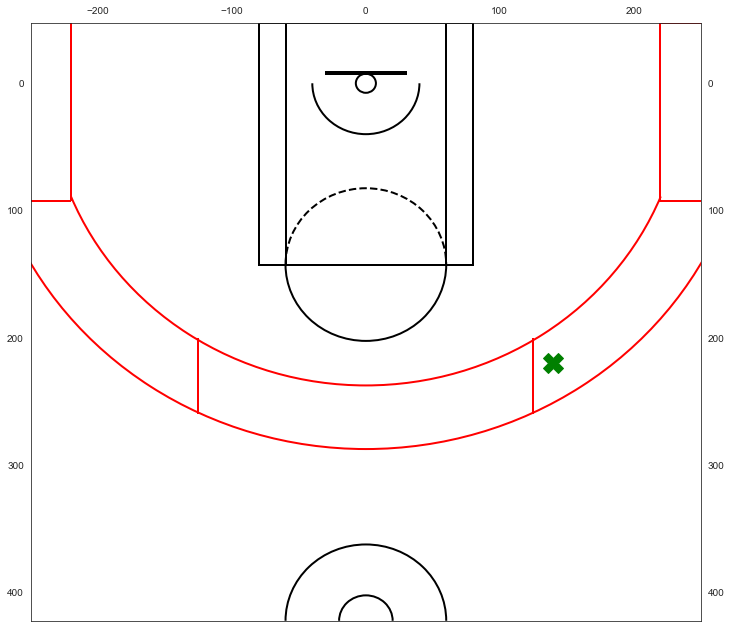

In [57]:
visualize_shot(140, 220)

In [30]:
## Left & Right Wing 2s
circle = Point(0,0).buffer(1)
three_circle = shapely.affinity.scale(circle, 237.5, 237.5)

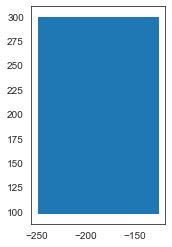

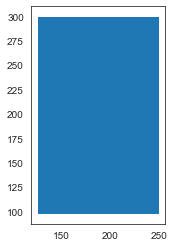

In [41]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import geopandas as gpd

polygon1 = Polygon([(-250, 97.5), (-250, 300), (-125, 300), (-125, 97.5)])
polygon2 = Polygon([(250, 97.5), (250, 300), (125, 300), (125, 97.5)])

p1 = gpd.GeoSeries(polygon1)
p2 = gpd.GeoSeries(polygon2)
p1.plot()
p2.plot()
plt.show()